### Dogs vs Cats Classification: Neural Network vs CNN

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

In [6]:
# Configuration
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 0.001
DATASET_PATH = 'dataset'

# Create dataset folder
os.makedirs(DATASET_PATH, exist_ok=True)

# Fix Kaggle API permissions
def fix_kaggle_permissions():
    kaggle_dir = os.path.expanduser('~/.kaggle')
    kaggle_json = os.path.join(kaggle_dir, 'kaggle.json')
    if os.path.exists(kaggle_json):
        os.chmod(kaggle_json, 0o600)
        # print("Fixed Kaggle API key permissions")

# Download dataset from Kaggle
def download_dataset():
    try:
        fix_kaggle_permissions()
        import kaggle
        if not os.path.exists(f'{DATASET_PATH}/dataset/training_set'):
            print('Downloading Dogs vs Cats dataset...')
            kaggle.api.dataset_download_files('chetankv/dogs-cats-images', path=DATASET_PATH, unzip=True)
            print('Dataset downloaded successfully!')
        else:
            print('Dataset already exists!')
        return True
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("Install kaggle package or download manually from:")
        print("https://www.kaggle.com/datasets/chetankv/dogs-cats-images")
        return False

# Download the dataset
download_dataset()

Dataset URL: https://www.kaggle.com/datasets/chetankv/dogs-cats-images
Dataset downloaded successfully!


True

In [7]:
training_path = Path(DATASET_PATH) / 'dataset' / 'training_set'

if training_path.exists():
    print(f"Loading dataset from: {training_path}")

    # Load dataset
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        training_path,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=None,
        seed=42,
        shuffle=True
    )

    # Get class names
    class_names = full_dataset.class_names
    print(f"Classes: {class_names}")

    # Count dataset size
    dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
    if dataset_size < 0:  # fallback if cardinality is unknown
        print("Counting dataset size manually...")
        dataset_size = sum(1 for _ in full_dataset)

    print(f"Total images: {dataset_size}")

    # Shuffle dataset
    full_dataset = full_dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split dataset: 70% train, 20% validation, 10% test
    train_size = int(0.7 * dataset_size)
    val_size = int(0.2 * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Split datasets
    train_dataset = full_dataset.take(train_size)
    remaining_dataset = full_dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    print(f"Dataset split - Train: {train_size}, Val: {val_size}, Test: {test_size}")

else:
    print("Dataset not found! Please download it first.")
    print(f"Expected path: {training_path}")


Loading dataset from: dataset\dataset\training_set
Found 8000 files belonging to 2 classes.
Classes: ['cats', 'dogs']
Total images: 8000
Dataset split - Train: 5600, Val: 1600, Test: 800


In [8]:
# Data preprocessing and augmentation
def preprocess_data(image, label):
    # Normalize pixel values to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augment_data(image, label):
    # Random horizontal flip for training data
    image = tf.image.random_flip_left_right(image)
    return image, label

# Apply preprocessing and augmentation
train_dataset = train_dataset.map(preprocess_data).map(augment_data)
val_dataset = val_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

# Batch and optimize for performance
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data preprocessing completed!")

Data preprocessing completed!


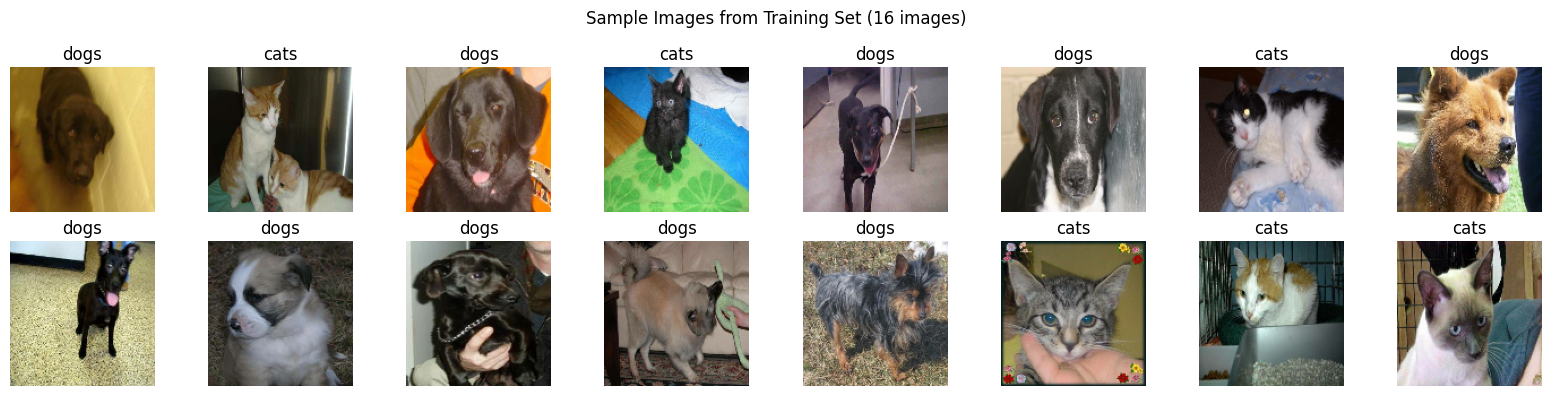

In [9]:
# Visualize sample images
plt.figure(figsize=(16, 4))
sample_count = 0
for images, labels in train_dataset.take(1):
    # Show first 16 images or available images if less
    num_images = min(16, len(images))
    for i in range(num_images):
        plt.subplot(2, 8, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis('off')
        sample_count += 1
    break

plt.suptitle(f'Sample Images from Training Set ({sample_count} images)')
plt.tight_layout()
plt.show()

### Simple Neural Network Model

In [10]:
# Build Simple Neural Network (fully connected)
simple_nn = models.Sequential([
    # Flatten 128x128x3 image into 49,152 features
    layers.Flatten(input_shape=(128, 128, 3)),
    
    # First layer: 49,152 inputs -> 512 outputs
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Second layer: 512 -> 256
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.5),
    
    # Third layer: 256 -> 128
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer: 128 -> 1 (binary classification)
    layers.Dense(1, activation='sigmoid')  # Output probability between 0 and 1
])

# Compile the model
simple_nn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
simple_nn.summary()
simple_nn_params = simple_nn.count_params()
print(f"\nSimple NN parameters: {simple_nn_params:,}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,334,273 (96.64 MB)

 Trainable params: 25,332,481 (96.64 MB)

 Non-trainable params: 1,792 (7.00 KB)


Simple NN parameters: 25,334,273


In [11]:
# Train Simple NN
print("Training Simple Neural Network...")

simple_nn_history = simple_nn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("Training completed!")

Training Simple Neural Network...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 32s 270ms/step - accuracy: 0.5259 - loss: 0.9076 - val_accuracy: 0.5394 - val_loss: 0.7765
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.5382 - loss: 0.8137 - val_accuracy: 0.5575 - val_loss: 0.7825
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 26s 260ms/step - accuracy: 0.5343 - loss: 0.7741 - val_accuracy: 0.5681 - val_loss: 0.6771
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 272ms/step - accuracy: 0.5561 - loss: 0.7347 - val_accuracy: 0.5844 - val_loss: 0.6888
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.5621 - loss: 0.7123 - val_accuracy: 0.6000 - val_loss: 0.6622
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.5702 - loss: 0.7013 - val_accuracy: 0.6031 - val_loss: 0.6565
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - accuracy: 0.5909 - loss: 0.6820 - val_accuracy: 0.5769 - val_loss: 0.6668
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 286ms/step - accuracy

In [12]:
# Test Simple NN
simple_nn_test_loss, simple_nn_accuracy = simple_nn.evaluate(test_dataset, verbose=0)
print(f"Simple NN Test Accuracy: {simple_nn_accuracy:.3f}")

Simple NN Test Accuracy: 0.567


### Convolutional Neural Network Model

In [13]:
# Build CNN (easier to understand with Sequential)
cnn = models.Sequential([
    # First convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # 128x128 -> 64x64
    
    # Second convolutional block  
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # 64x64 -> 32x32
    
    # Third convolutional block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # 32x32 -> 16x16
    
    # Fourth convolutional block
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2),  # 16x16 -> 8x8
    
    # Flatten for fully connected layers
    layers.Flatten(),  # 256 * 8 * 8 = 16,384 features
    
    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    # Output layer
    layers.Dense(1, activation='sigmoid')  # Output probability between 0 and 1
])

# Compile the model
cnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
cnn.summary()
cnn_params = cnn.count_params()
print(f"\nCNN parameters: {cnn_params:,}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,847,809 (33.75 MB)

 Trainable params: 8,845,569 (33.74 MB)

 Non-trainable params: 2,240 (8.75 KB)


CNN parameters: 8,847,809


In [14]:
# Train CNN
print("Training CNN...")

cnn_history = cnn.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

print("Training completed!")

Training CNN...
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6173 - loss: 0.7942 - val_accuracy: 0.5100 - val_loss: 1.4057
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.6625 - loss: 0.6585 - val_accuracy: 0.5025 - val_loss: 1.3947
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7243 - loss: 0.5664 - val_accuracy: 0.4731 - val_loss: 1.4739
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.7609 - loss: 0.5041 - val_accuracy: 0.5144 - val_loss: 1.2537
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.7930 - loss: 0.4526 - val_accuracy: 0.5263 - val_loss: 1.3327
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8093 - loss: 0.4167 - val_accuracy: 0.7487 - val_loss: 0.4719
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8314 - loss: 0.3860 - val_accuracy: 0.7837 - val_loss: 0.4688
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8450 - loss: 0.3516 - val_accu

In [15]:
# Test CNN
cnn_test_loss, cnn_accuracy = cnn.evaluate(test_dataset, verbose=0)
print(f"CNN Test Accuracy: {cnn_accuracy:.3f}")

CNN Test Accuracy: 0.936


### Model Comparison and Analysis


Comparison Results:
Simple NN parameters: 25,334,273
CNN parameters:       8,847,809
Simple NN accuracy:   0.567
CNN accuracy:         0.936
Improvement:          36.9 percentage points


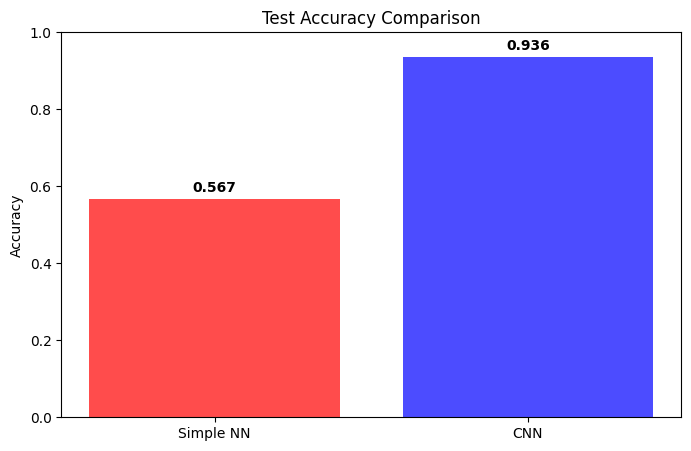

In [16]:
# Compare results
print("\nComparison Results:")
print("="*30)
print(f"Simple NN parameters: {simple_nn_params:,}")
print(f"CNN parameters:       {cnn_params:,}")
print(f"Simple NN accuracy:   {simple_nn_accuracy:.3f}")
print(f"CNN accuracy:         {cnn_accuracy:.3f}")
print(f"Improvement:          {(cnn_accuracy - simple_nn_accuracy)*100:.1f} percentage points")

# Simple bar chart
models = ['Simple NN', 'CNN']
accuracies = [simple_nn_accuracy, cnn_accuracy]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['red', 'blue'], alpha=0.7)
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.show()

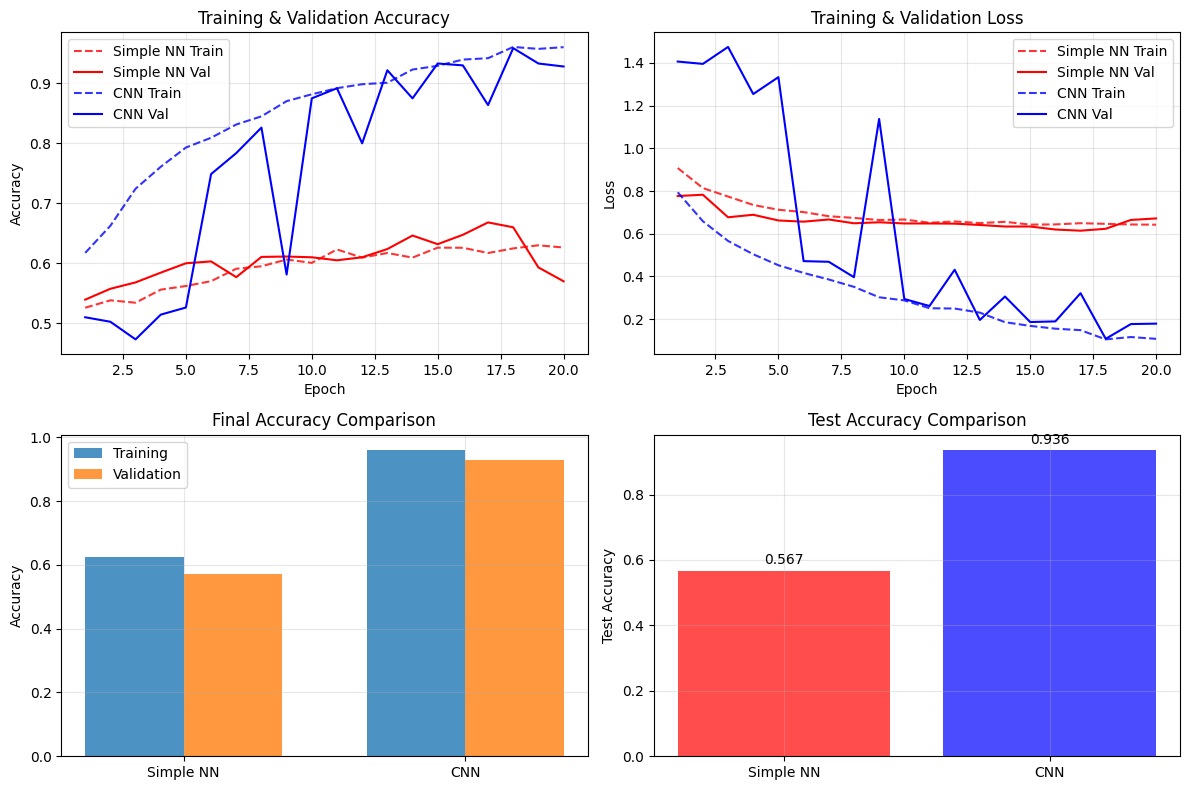

In [17]:
# Training curves comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
epochs = range(1, EPOCHS + 1)

# Accuracy curves
ax1.plot(epochs, simple_nn_history.history['accuracy'], 'r--', label='Simple NN Train', alpha=0.8)
ax1.plot(epochs, simple_nn_history.history['val_accuracy'], 'r-', label='Simple NN Val')
ax1.plot(epochs, cnn_history.history['accuracy'], 'b--', label='CNN Train', alpha=0.8)
ax1.plot(epochs, cnn_history.history['val_accuracy'], 'b-', label='CNN Val')
ax1.set_title('Training & Validation Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Loss curves
ax2.plot(epochs, simple_nn_history.history['loss'], 'r--', label='Simple NN Train', alpha=0.8)
ax2.plot(epochs, simple_nn_history.history['val_loss'], 'r-', label='Simple NN Val')
ax2.plot(epochs, cnn_history.history['loss'], 'b--', label='CNN Train', alpha=0.8)
ax2.plot(epochs, cnn_history.history['val_loss'], 'b-', label='CNN Val')
ax2.set_title('Training & Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Final accuracy comparison
models = ['Simple NN', 'CNN']
final_train = [simple_nn_history.history['accuracy'][-1], cnn_history.history['accuracy'][-1]]
final_val = [simple_nn_history.history['val_accuracy'][-1], cnn_history.history['val_accuracy'][-1]]

x = np.arange(len(models))
width = 0.35

ax3.bar(x - width/2, final_train, width, label='Training', alpha=0.8)
ax3.bar(x + width/2, final_val, width, label='Validation', alpha=0.8)
ax3.set_title('Final Accuracy Comparison')
ax3.set_ylabel('Accuracy')
ax3.set_xticks(x)
ax3.set_xticklabels(models)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Test accuracy comparison
test_accs = [simple_nn_accuracy, cnn_accuracy]
bars = ax4.bar(models, test_accs, color=['red', 'blue'], alpha=0.7)
ax4.set_title('Test Accuracy Comparison')
ax4.set_ylabel('Test Accuracy')
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

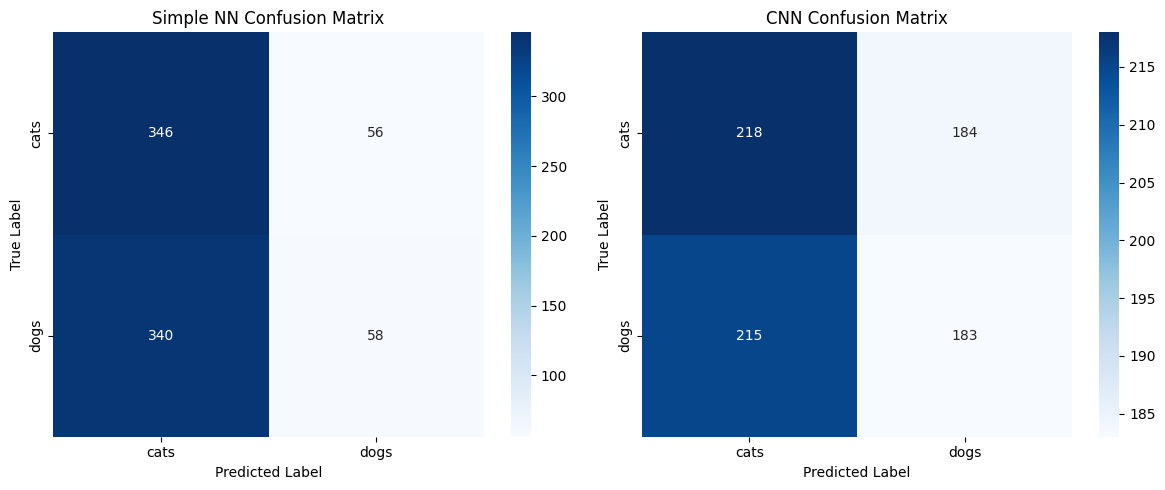

In [18]:
# Get predictions for confusion matrix
simple_nn_predictions = simple_nn.predict(test_dataset, verbose=0)
cnn_predictions = cnn.predict(test_dataset, verbose=0)

# Get true labels
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Convert predictions to binary
simple_nn_pred_binary = (simple_nn_predictions > 0.5).astype(int).flatten()
cnn_pred_binary = (cnn_predictions > 0.5).astype(int).flatten()

# Confusion matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Simple NN confusion matrix
cm_simple = confusion_matrix(true_labels, simple_nn_pred_binary)
sns.heatmap(cm_simple, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_title('Simple NN Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# CNN confusion matrix
cm_cnn = confusion_matrix(true_labels, cnn_pred_binary)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=ax2)
ax2.set_title('CNN Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [19]:
# Performance summary
summary_data = {
    'Model': ['Simple NN', 'CNN'],
    'Parameters': [f"{simple_nn_params:,}", f"{cnn_params:,}"],
    'Best Val Acc': [f"{max(simple_nn_history.history['val_accuracy']):.3f}", 
                     f"{max(cnn_history.history['val_accuracy']):.3f}"],
    'Test Acc': [f"{simple_nn_accuracy:.3f}", f"{cnn_accuracy:.3f}"]
}

summary_df = pd.DataFrame(summary_data)
print("Model Performance Summary:")
print(summary_df.to_string(index=False))

# Key insights
acc_improvement = (cnn_accuracy - simple_nn_accuracy) * 100
param_ratio = simple_nn_params / cnn_params

print(f"\nKey Results:")
print(f"• CNN achieves {acc_improvement:.1f} percentage points better test accuracy")
print(f"• CNN uses {param_ratio:.1f}x fewer parameters than Simple NN")
print(f"• CNN shows better feature learning through convolutional layers")

Model Performance Summary:
    Model Parameters Best Val Acc Test Acc
Simple NN 25,334,273        0.668    0.567
      CNN  8,847,809        0.959    0.936

Key Results:
• CNN achieves 36.9 percentage points better test accuracy
• CNN uses 2.9x fewer parameters than Simple NN
• CNN shows better feature learning through convolutional layers


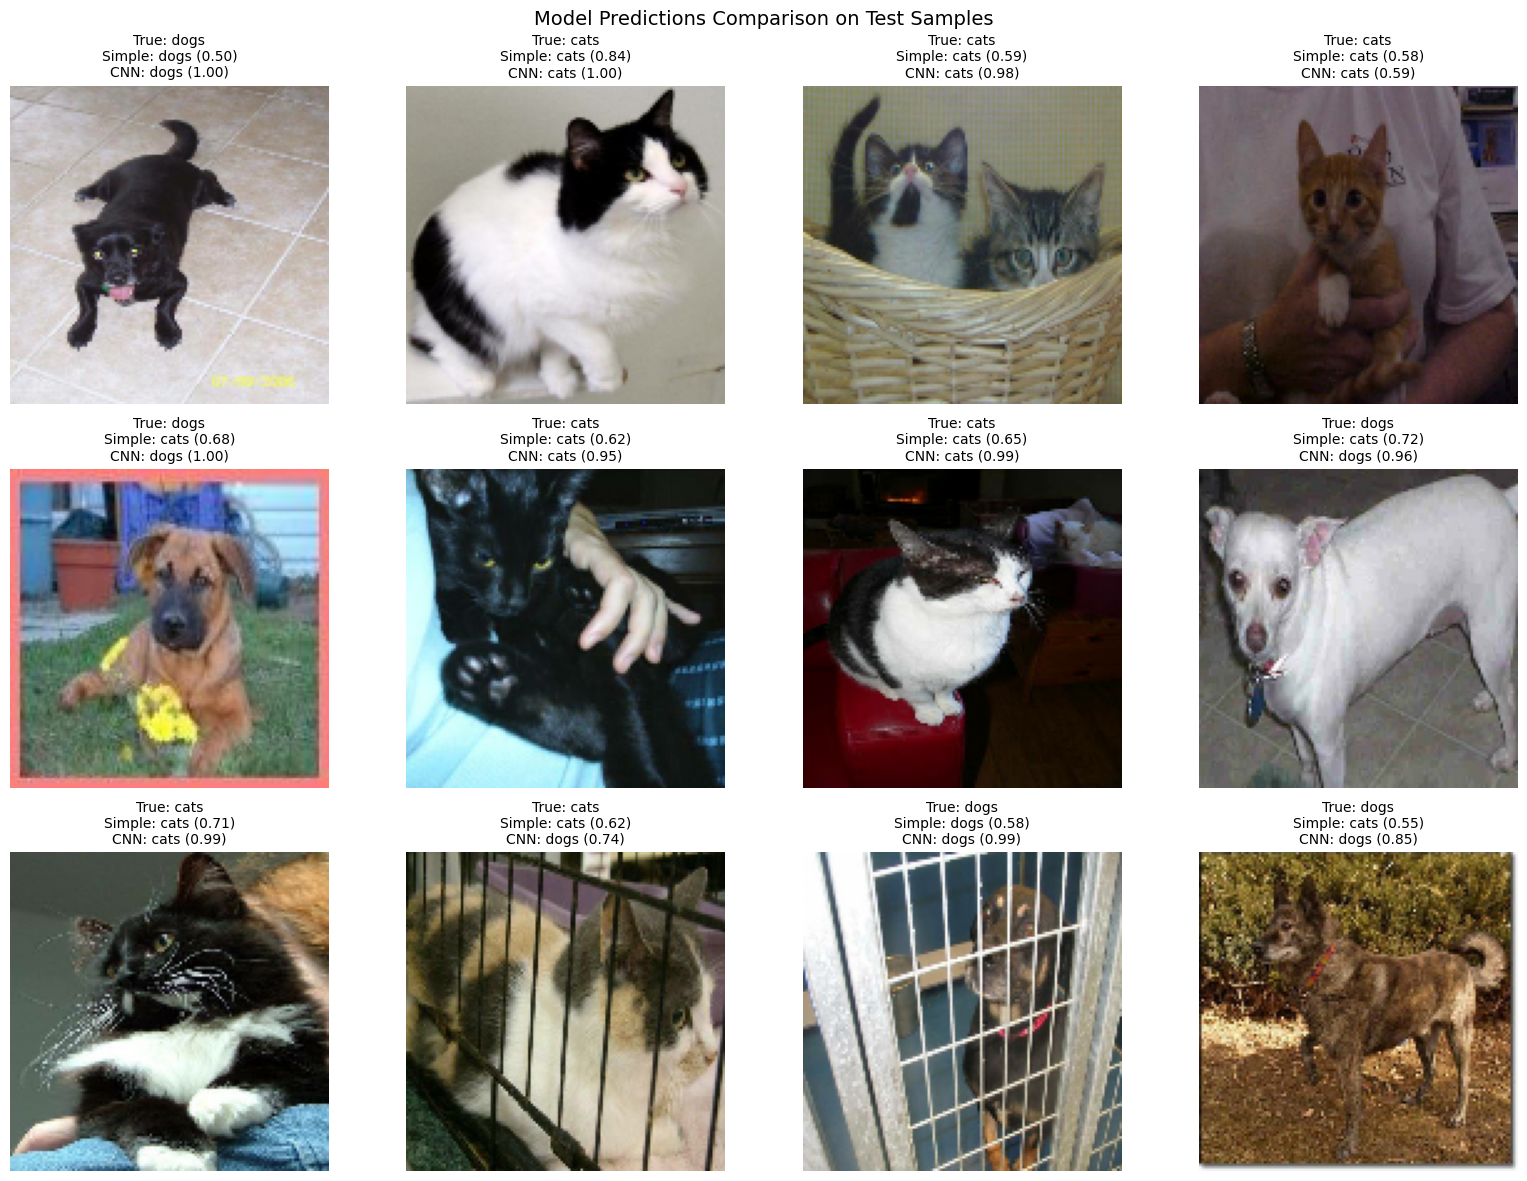

Sample Analysis (12 images):
Simple NN correct: 9/12 (75.0%)
CNN correct: 11/12 (91.7%)
Both correct: 8/12 (66.7%)
Models agree: 8/12 (66.7%)


In [20]:
# Sample prediction comparison
# Get a batch of test images
for test_images, test_labels in test_dataset.take(1):
    sample_images = test_images[:12]
    sample_labels = test_labels[:12]
    
    # Get predictions
    simple_preds = simple_nn.predict(sample_images, verbose=0)
    cnn_preds = cnn.predict(sample_images, verbose=0)
    
    # Convert to binary predictions
    simple_pred_binary = (simple_preds > 0.5).astype(int).flatten()
    cnn_pred_binary = (cnn_preds > 0.5).astype(int).flatten()
    
    # Plot comparison
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    for i in range(12):
        row = i // 4
        col = i % 4
        
        axes[row, col].imshow(sample_images[i])
        
        true_label = class_names[sample_labels[i]]
        simple_label = class_names[simple_pred_binary[i]]
        cnn_label = class_names[cnn_pred_binary[i]]
        
        simple_conf = simple_preds[i][0] if simple_preds[i][0] > 0.5 else 1 - simple_preds[i][0]
        cnn_conf = cnn_preds[i][0] if cnn_preds[i][0] > 0.5 else 1 - cnn_preds[i][0]
        
        title = f"True: {true_label}\nSimple: {simple_label} ({simple_conf:.2f})\nCNN: {cnn_label} ({cnn_conf:.2f})"
        axes[row, col].set_title(title, fontsize=10)
        axes[row, col].axis('off')
    
    plt.suptitle('Model Predictions Comparison on Test Samples', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Agreement analysis
    simple_correct = (simple_pred_binary == sample_labels.numpy()).sum()
    cnn_correct = (cnn_pred_binary == sample_labels.numpy()).sum()
    both_correct = ((simple_pred_binary == sample_labels.numpy()) & 
                   (cnn_pred_binary == sample_labels.numpy())).sum()
    agreement = (simple_pred_binary == cnn_pred_binary).sum()
    
    print(f"Sample Analysis (12 images):")
    print(f"Simple NN correct: {simple_correct}/12 ({simple_correct/12*100:.1f}%)")
    print(f"CNN correct: {cnn_correct}/12 ({cnn_correct/12*100:.1f}%)")
    print(f"Both correct: {both_correct}/12 ({both_correct/12*100:.1f}%)")
    print(f"Models agree: {agreement}/12 ({agreement/12*100:.1f}%)")
    
    break